In [2]:
import numpy as np
import pandas as pd
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt

tfd = tfp.distributions

## Exercises

### Sample survey
Suppose we are going to sample 100 individuals from a county (of size much larger than 100) and ask each sampled person whether they support policy Z or not. Let $Y_{i}=1$ if person i in the sample supports the policy, and $Y_{i}=0$ otherwise.

a) Assume $Y_{1},...,Y_{100}$ are, conditional on $\theta$, i.i.d. binary random variables with expectation $\theta$. Write down the join distribution of $Pr(Y_{1}=y{1},...,Y_{100}=y_{100}|\theta)$ in compact form. Also write down the form of $Pr(\sum Y_{i}=y|\theta)$.

Solution:
$$
Pr(Y_{1}=y_{1},...,Y_{100}=y_{100}|\theta) = \theta^{\sum_{i=1}^{100} y_{i}} (1-\theta)^{100-\sum_{i=1}^{100} y_{i}}
$$

$$
Pr(\sum Y_{i}|\theta) = \binom{100}{y}\theta^{y}(1-\theta)^{100-y}
$$

b) For the moment, suppose you believed that $\theta \in \{0.0, 0.1, ..., 0.9, 1.0\}$. Given that the results of the survey were $\sum_{i=1}^{100} Y_{i} = 57$, compute $Pr(\sum Y_{i}=57|\theta)$ for each of these 11 values of $\theta$ and plot these probabilities as a function of $\theta$.

In [17]:
def likelihood(theta, y):
    return theta**y * (1-theta)**(100-y)

sum_y_i = 57
theta_grid = np.arange(0.0, 1.1, 0.1)
likelihood_grid = likelihood(theta_grid, sum_y_i)

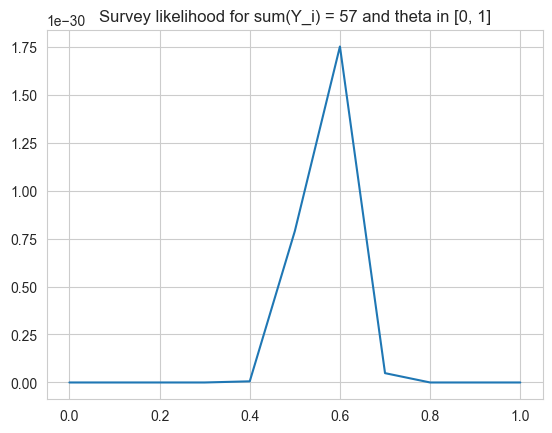

In [19]:
sns.lineplot(x=theta_grid, y=likelihood_grid)

plt.title("Survey likelihood for sum(Y_i) = 57 and theta in [0, 1]")
plt.show()

c) Now suppose you originally had no prior information to believe one of these $\theta$-values over another, and so $Pr(\theta=0.0)=...=Pr(\theta=1.0)$. Use Bayes rule to compute $p(\theta|\sum_{i=1}^{n} Y_{i} = 57)$ for each $\theta$-value. Make a plot of this posterior distribution as a function of $\theta$.

$$
Pr(\theta|\sum Y_{i}=57) = \frac{Pr(\sum Y_{i}=57|\theta)Pr(\theta)}{Pr(\sum Y_{i}=57)} = \frac{p(\sum Y_{i}=57|\theta)p(\theta)}{\sum p(\sum_{\theta'} Y_{i}=57|\theta')p(\theta')} \propto p(\sum Y_{i}=57|\theta)
$$

Posterior distribution has the same shape, but different scale (take a look at y-axis).

In [26]:
posterior_grid = likelihood(theta_grid, sum_y_i) / np.sum(likelihood_grid)

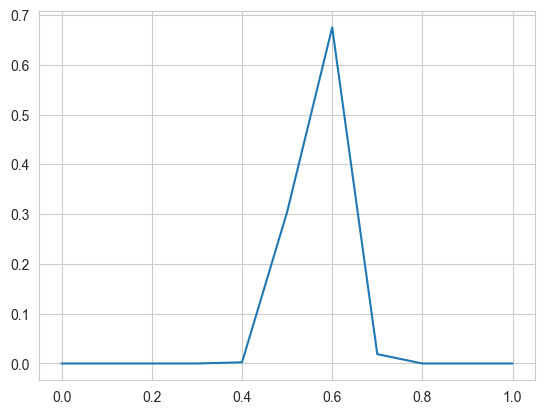

In [27]:
sns.lineplot(x=theta_grid, y=posterior_grid)

plt.show()

d) Now suppose you allow $\theta$ to be any value in the interval $[0, 1]$. Using the uniform prior density for $\theta$, so that $p(\theta)=1$, plot the posterior density $p(\theta)Pr(\sum Y_{i=1}^{n} = 57 | \theta)$ as a function of $\theta$.

In [28]:
def prior(_):
    return 1

theta_grid = np.linspace(0.0, 1.0, 1000)
posterior_grid = likelihood(theta_grid, sum_y_i) * prior(theta_grid)

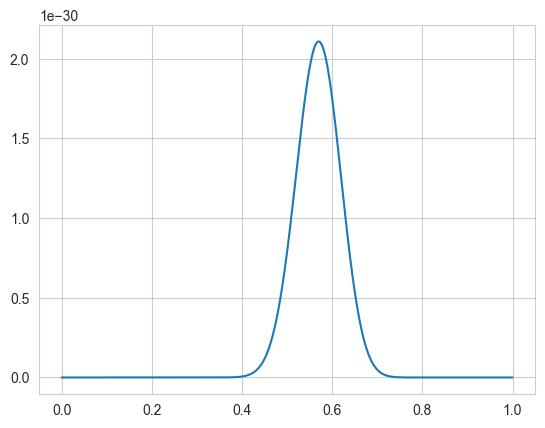

In [30]:
sns.lineplot(x=theta_grid, y=posterior_grid)

plt.show()

### Sensitivity analysis

It is sometimes useful to express the parameters a and b in a beta distribution in terms $\theta_{0}=\fact{a}{a+b}$ and $n_{0}=a+b$, so that $a=\theta_{0}n_{0}$ and $b=(1-\theta_{0})n_{0}$. Reconsidering the sample survey data from exercises above, for each combination of $\theta_{0} \in \{0.1, 0.2, ... , 0.9\}$ and $n_{0} \in \{1,2,8,16,32\}$ find the corresponding a,b values and compute $Pr(\theta > 0.5 | \sum Y_{i}=57)$ using a beta(a, b) prior distribution for $\theta$. Display the results with a contour plot, and discuss how the plot could be used to explain to someone whether or not hey should believe that $\theta > 0.5$, based on the data that $\sum_{i=1}^{100} Y_{i}=57$.

In [75]:
def prior_distribution(theta_0, n_0):
    a = theta_0 * n_0
    b = (1 - theta_0) * n_0

    return tfd.Beta(a, b)

def posterior_distribution(a_, b_, y_, n_):
    a = a_ + y_
    b = b_ + n_ - y_

    return tfd.Beta(a, b)

theta_0_values = np.arange(0.0, 1.0, 0.1)
n_0_values = np.arange(0, 32, 0.5)
y, n = 57, 100

posterior_grid = np.zeros((len(theta_0_values), len(n_0_values)))
for i, theta_0 in enumerate(theta_0_values):
    for j, n_0 in enumerate(n_0_values):
        prior = prior_distribution(theta_0, n_0)
        posterior = posterior_distribution(prior.concentration1, prior.concentration0, y, n)
        posterior_grid[i, j] = posterior.prob(0.5)

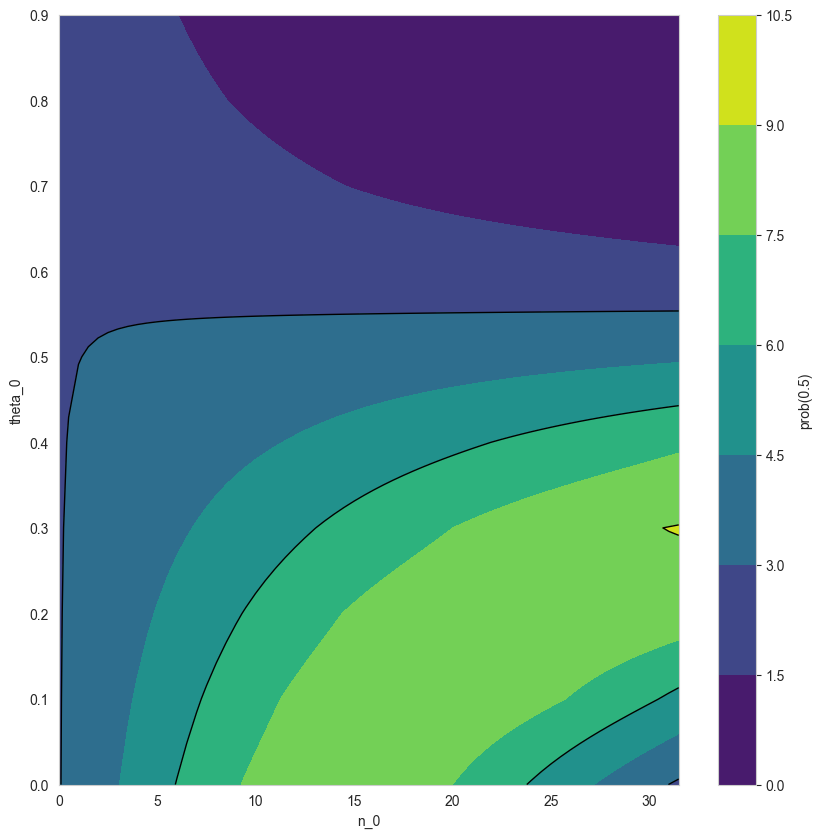

In [79]:
contour_fig, contour_ax = plt.subplots(figsize=(10, 10))

CS = contour_ax.contourf(n_0_values, theta_0_values, posterior_grid, cmap=plt.cm.viridis)
CS2 = contour_ax.contour(CS, levels=CS.levels[::2], colors='k', linewidths=1)

contour_cbar = contour_fig.colorbar(CS)
contour_cbar.ax.set_ylabel("prob(0.5)")
contour_ax.set_xlabel("n_0")
contour_ax.set_ylabel("theta_0")

plt.show()

### Tumor counts

A cancer laboratory is estimating the rate of the tumorigenesis in two strains of mice, A and B. They have tumor count data for 10 mice in strain A and 13 mice in strain B. Type A mice have been well studied, and information from other laboratories suggests that type A mice have tumor counts that are approximately Poisson-distributed with a mean of 12. Tumor count rates for type B mice are unknown, but type B mice are related to type A mice. The observed tumor counts for the two populations are:
- $y_{A}=(12, 9, 12, 14, 13, 13, 15, 8, 15, 6)$
- $y_{B}=(11, 11, 10, 9, 9, 8, 7, 10, 6, 8, 8, 9, 7)$

a) Find the posterior distribution, means, variances and 95% quantile-based confidence intervals for $\theta_{A}$ and $\theta_{B}$, assuming a Poisson sampling distribution for each group and the following prior distribution:

$$ \theta_{A} \sim \text{gamma}(120, 10), \theta_{B} \sim \text{Gamma}(12, 1), p(\theta_{A}, \theta_{B})=p(\theta_{A})p(\theta_{B}) $$

In [92]:
y_a = np.array([12, 9, 12, 14, 13, 13, 15, 8, 15, 6])
y_b = np.array([11, 11, 10, 9, 9, 8, 7, 10, 6, 8, 8, 9, 7])

def prior_gamma(a_, b_):
    return tfd.Gamma(a_, b_)

def posterior_gamma(a_, b_, y_):
    a = a_ + np.sum(y_)
    b = b_ + len(y_)

    return tfd.Gamma(a, b)

theta_a_prior = prior_gamma(120, 10)
theta_b_prior = prior_gamma(12, 1)

theta_a_posterior = posterior_gamma(theta_a_prior.concentration, theta_a_prior.rate, y_a)
theta_b_posterior = posterior_gamma(theta_b_prior.concentration, theta_b_prior.rate, y_b)

theta_a_samples = theta_a_posterior.sample(10000)
theta_b_samples = theta_b_posterior.sample(10000)

theta_a_mean, theta_a_variance, theta_a_95_ci = np.mean(theta_a_samples), np.var(theta_a_samples), np.quantile(theta_a_samples, [0.025, 0.975])

theta_b_mean, theta_b_variance, theta_b_95_ci = np.mean(theta_b_samples), np.var(theta_b_samples), np.quantile(theta_b_samples, [0.025, 0.975])

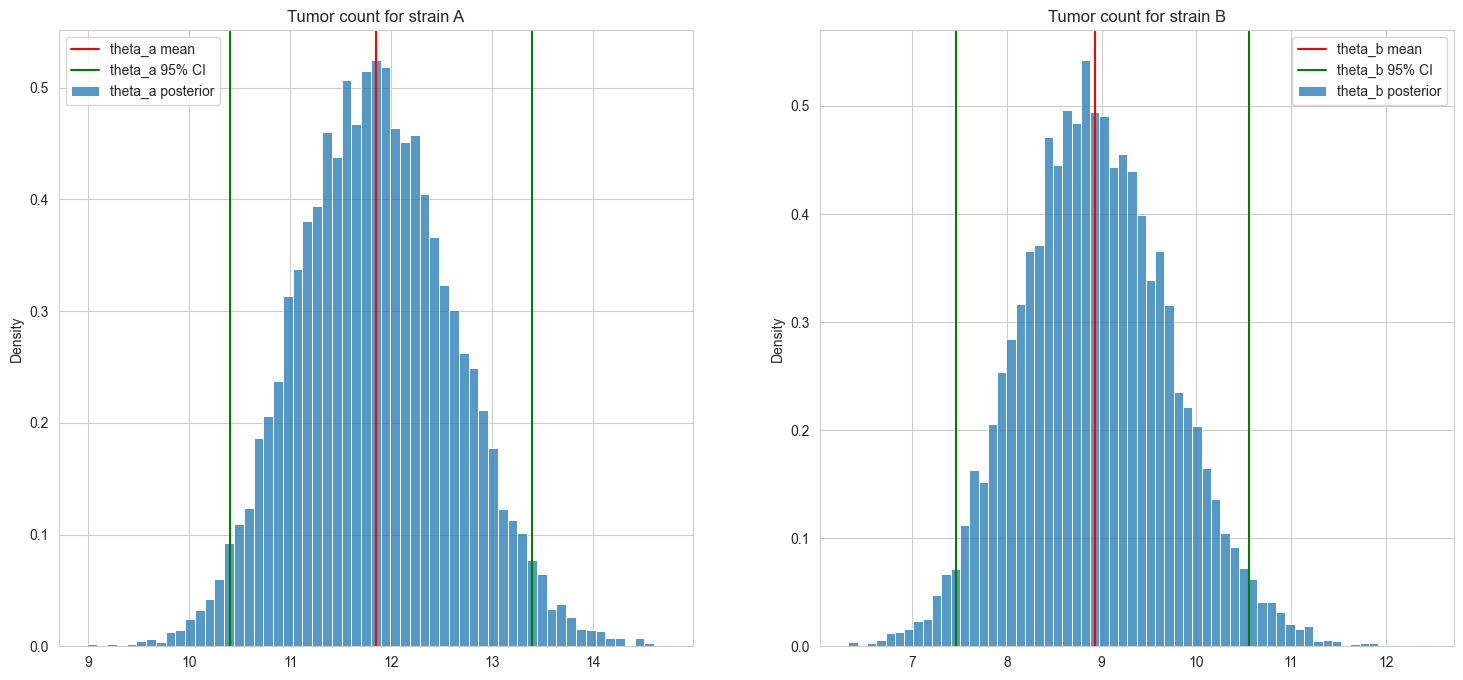

In [105]:
_, tumor_count_ax = plt.subplots(1, 2, figsize=(18, 8))

sns.histplot(theta_a_samples, stat="density", label="theta_a posterior", ax=tumor_count_ax[0])
tumor_count_ax[0].axvline(theta_a_mean, color="red", label="theta_a mean")
tumor_count_ax[0].axvline(theta_a_95_ci[0], color="green", label="theta_a 95% CI")
tumor_count_ax[0].axvline(theta_a_95_ci[1], color="green")
tumor_count_ax[0].legend()
tumor_count_ax[0].set_title("Tumor count for strain A")

sns.histplot(theta_b_samples, stat="density", label="theta_b posterior", ax=tumor_count_ax[1])
tumor_count_ax[1].axvline(theta_b_mean, color="red", label="theta_b mean")
tumor_count_ax[1].axvline(theta_b_95_ci[0], color="green", label="theta_b 95% CI")
tumor_count_ax[1].axvline(theta_b_95_ci[1], color="green")
tumor_count_ax[1].legend()
tumor_count_ax[1].set_title("Tumor count for strain B")


plt.show()

b) Compute and plot the posterior expectation of $\theta_{B}$ under the prior distribution $\theta_{B} \sim gamma(12n_{0},n_{0})$ for each value of $n_{0} \in \{1,2,...,50 \}$. Describe what sort of prior beliefs about $\theta_{B}$ would be necessary in order for the posterior expectation of $\theta_{B}$ to be close to that of $\theta_{B}$

In [124]:
n_0 = np.arange(1, 51)

theta_b_prior = prior_gamma(12 * n_0, n_0)
theta_b_posterior = posterior_gamma(theta_b_prior.concentration, theta_b_prior.rate, y_b)
theta_b_posterior_mean = theta_b_posterior.mean()

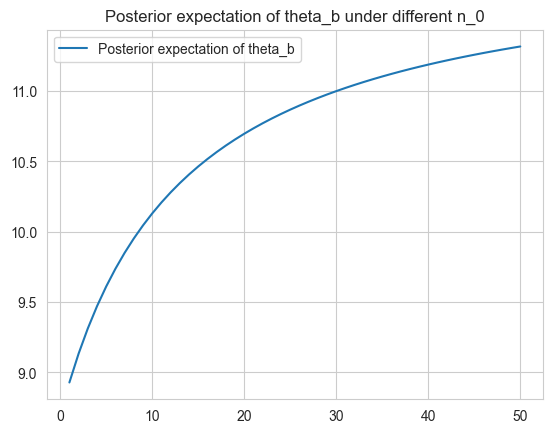

In [131]:
sns.lineplot(x=n_0, y=theta_b_posterior_mean, label="Posterior expectation of theta_b")

plt.title("Posterior expectation of theta_b under different n_0")
plt.show()

According to graph, $n_{0}$ should be close to 50 in order to achieve the same posterior expectation of $\theta_{B}$ as $\theta_{A}$.

c) Should knowledge about population A tell us anything about population B? Discuss whether or not it make sense to have $p(\theta_{A}, \theta_{B})=p(\theta_{A})p(\theta_{B})$.

We have existing knowledge about population A and so knowing that B is related with it, we use these beliefs into our prior for population B. It is possible that the parameter of B is quite different from A, so we should view the population as independent.

### Mixtures of beta priors

Estimate the probability $\theta$ of teen recidivism based on a study in which there were $n=43$ individuals released from incarceration and $y=15$ re-offenders within 36 months.

a) Using a $beta(2, 8)$ prior for $\theta$, plot $p(\theta)$, $p(y|\theta)$ and $p(\theta|y)$ as functions of $\theta$. Find the posterior mean, mode, and standard deviation of $\theta$. Find 95% quantile-based confidence intervals.

In [139]:
def posterior_beta(a_, b_, n_, y_):
    a = a_ + y_
    b = b_ + n_ - y_

    return tfd.Beta(a, b)

a, b, n, y = 2, 8, 43, 15

theta_posterior = posterior_beta(a, b, n, y)
theta_samples = theta_posterior.sample(10000)

theta_mean, theta_variance, theta_95_ci = np.mean(theta_samples), np.var(theta_samples), np.quantile(theta_samples, [0.025, 0.975])

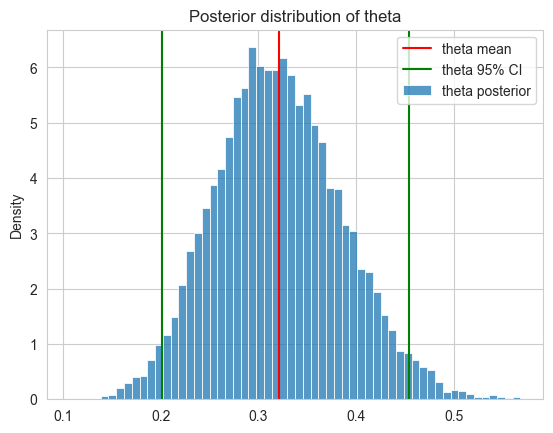

In [141]:
sns.histplot(theta_samples, stat="density", label="theta posterior")
plt.axvline(theta_mean, color="red", label="theta mean")
plt.axvline(theta_95_ci[0], color="green", label="theta 95% CI")
plt.axvline(theta_95_ci[1], color="green")
plt.legend()
plt.title("Posterior distribution of theta")
plt.show()

b) Repeat a), but using a $beta(8,2)$ prior for $\theta$

In [142]:
a, b, n, y = 8, 2, 43, 15

theta_posterior = posterior_beta(a, b, n, y)
theta_samples = theta_posterior.sample(10000)
theta_mean, theta_variance, theta_95_ci = np.mean(theta_samples), np.var(theta_samples), np.quantile(theta_samples, [0.025, 0.975])

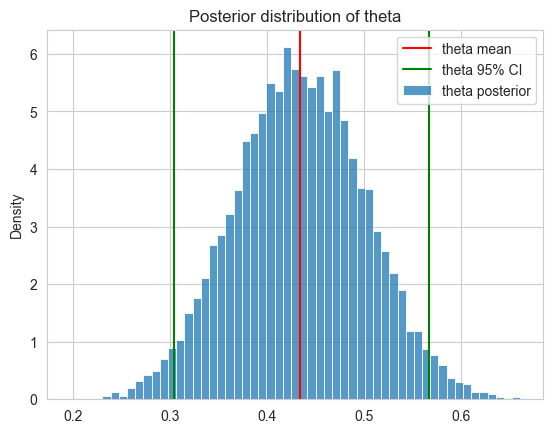

In [143]:
sns.histplot(theta_samples, stat="density", label="theta posterior")
plt.axvline(theta_mean, color="red", label="theta mean")
plt.axvline(theta_95_ci[0], color="green", label="theta 95% CI")
plt.axvline(theta_95_ci[1], color="green")
plt.legend()
plt.title("Posterior distribution of theta")
plt.show()

c) Consider the following prior distributions for $\theta$:

$$
p(\theta) = \frac{1}{4}\frac{\Gamma(10)}{\Gamma(2)\Gamma(8)}[3\theta(1-\theta)^7 + \theta^7(1-\theta))]
$$

which is a 75-25% mixture of a beta(2,8) and a beta(8,2) prior distribution. Plot this prior distribution and compare it to the priors in a) and b). Describe what sort of prior opinion this may represent.

d) For the prior in c):
    - Write out mathematically $p(\theta)p(y|\theta)$ and simplify as much as possible.
    - The posterior distribution is a mixture of two distributions you know. Identify these distributions.
    - On a computer, calculate and plot $p(\theta)p(y|\theta)$ for a variety of values. Also find (approximately) the posterior mode, and discuss its relation to the modes in a) and b).

In [13]:
def custom_prior(theta):
    return 0.25 * (3 * theta * (1 - theta) ** 7 + theta ** 7 * (1 - theta))

def custom_posterior(theta_, n_, y_):
    r = 3*theta_**16*(1-theta_)**35 + theta_**22*(1-theta_)**29
    return r


theta_values = np.linspace(0, 1, 1000)
custom_theta_prior = custom_prior(theta_values)
custom_theta_posterior = custom_posterior(theta_values, 43, 15)

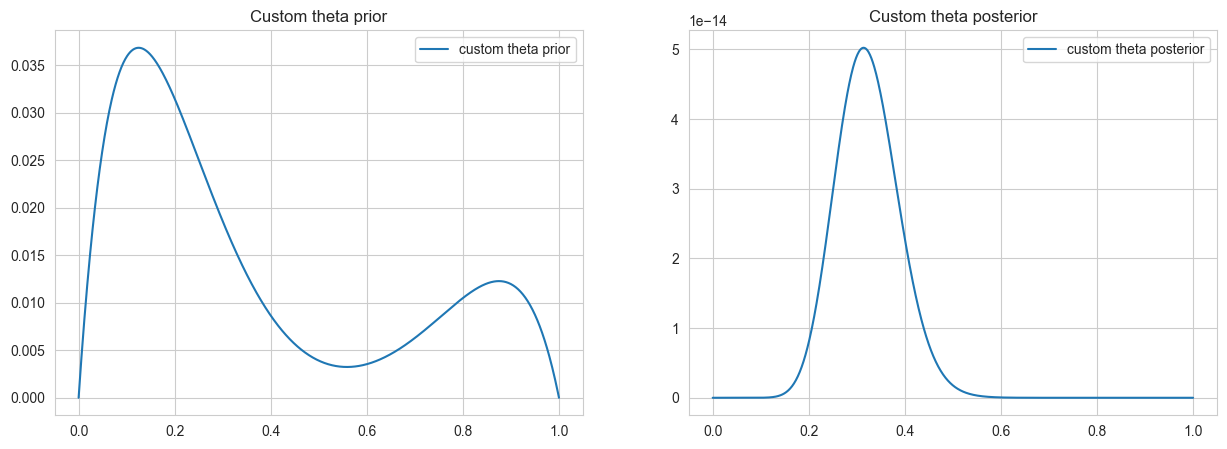

In [17]:
_, mixture_beta_ax = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x=theta_values, y=custom_theta_prior, label="custom theta prior", ax=mixture_beta_ax[0])
sns.lineplot(x=theta_values, y=custom_theta_posterior, label="custom theta posterior", ax=mixture_beta_ax[1])
mixture_beta_ax[0].set_title("Custom theta prior")
mixture_beta_ax[1].set_title("Custom theta posterior")

plt.show()

### Posterior prediction

Consider a pilot study in which $n_{1}=15$ children enrolled in special education classes were randomly selected and tested for a certain type of learning disability. In the pilot study $y_{1}=2$ children tested positive for the disability.

a) Using a uniform prior distribution, find the posterior distribution of $\theta$, the fraction of students in special education classes who have the disability. Find the posterior mean, mode and standard deviation of $\theta$, and plot the posterior density.



In [31]:
def prior(_):
    return 1

def posterior(a_, b_, n_, y_):
    return tfd.Beta(a_ + y_, b_ + n_ - y_)

a, b, n, y = 1, 1, 15, 2
disability_posterior = posterior(a, b, n, y)
disability_samples = disability_posterior.sample(10000)
disability_mean, disability_std, disability_mode = np.mean(disability_samples), np.std(disability_samples), disability_posterior.mode()

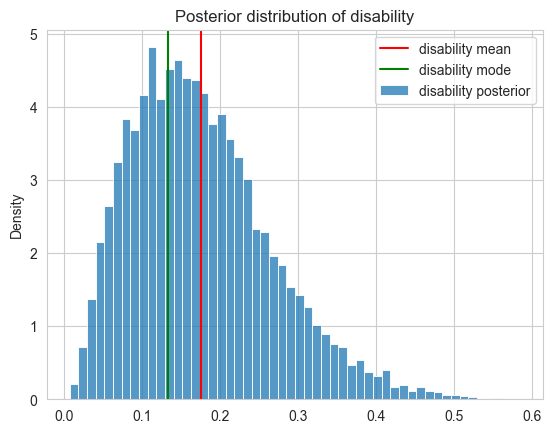

In [32]:
sns.histplot(disability_samples, stat="density", label="disability posterior")
plt.axvline(disability_mean, color="red", label="disability mean")
plt.axvline(disability_mode, color="green", label="disability mode")
plt.legend()
plt.title("Posterior distribution of disability")
plt.show()

In [34]:
print(f"Posterior mean: {disability_mean}")
print(f"Posterior mode: {disability_mode}")
print(f"Posterior standard deviation: {disability_std}")

Posterior mean: 0.1756066232919693
Posterior mode: 0.13333332538604736
Posterior standard deviation: 0.08989713340997696


Researches would like to recruit students with the disability to participate in a long-term study, but first they need to make sure they can recruit enough students. Let $n_{2}=278$ be the number of children in special education classes in this particular school district, and let $Y_{2}$ be the number of students with the disability.

b) Find $Pr(Y_{2} = y_{2} | Y_{1}=1)$, the posterior predictive distribution of Y_{2}, as follows:
i. Discuss what assumptions are needed about the joint distribution of $(Y_{1}, Y_{2})$ such that the following is true:

$$
Pr(Y_{2}=y_{2}|Y_{1}=2) = \int_{0}^{1}Pr(Y_{2}=y_{2}|\theta)Pr(\theta|Y_{1}=2)d\theta
$$

An important feature of Bayesian inference is the existence of a predictive distribution for new observations.Two important things about the predictive distribution is that predictive distribution does not depend on any unknown quantities and predictive distribution depends on our observed data, so $Y_{2}$ is not independent of $Y_{1}$. So (Y_{1}, Y_{2}) is not independent.

ii. Now plug in the forms of $Pr(Y_{2}=y_{2} | \theta)$ and $p(\theta|Y_{1}=2)$ in the above integral.

$$
Pr(Y_{2}=y_{2}|Y_{1}=2) = \int_{0}^{1}Pr(Y_{2}=y_{2}|\theta)Pr(\theta|Y_{1}=2)d\theta = \int_{0}^{1} \theta^{y_{2}}(1-\theta)^{278-y_{2}}\theta^{2}(1-\theta)^{13}d\theta=\int_{0}^{1} \theta^{y_{2} + 2}(1-\theta)^{278-y_{2} + 13}d\theta \sim beta(y_{2} + 3, 290 + y_{2})
$$

c) Plot the function $Pr(Y_{2}=y_{2}|Y_{1}=2)$ as a function of $y_{2}$. Obtain the mean and standard deviation of $Y_{2}$ given $Y_{1}=2$.

In [97]:
def posterior_predictive(a_, b_, y_, n_):
    return tfd.BetaBinomial(total_count=n_, concentration1=a_ + y_, concentration0=b_ + n_ - y_)

a, b, n = 3, 14, 278
y_values = np.linspace(1, 279, 279)

posterior_predictive_distribution = posterior_predictive(a, b, y_values, n)

<AxesSubplot:>

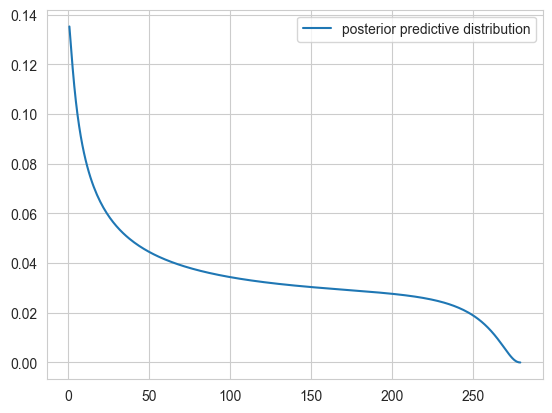

In [100]:
sns.lineplot(x=y_values, y=posterior_predictive_distribution.prob(y_values), label="posterior predictive distribution")